In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_row',None)
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋
testfile = '../../data/test.csv'
test_df = pd.read_csv(testfile)

stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)
total_df["PINS"].iloc[:5]

Date
2019-01-02    24.99
2019-01-03    24.99
2019-01-04    24.99
2019-01-07    24.99
2019-01-08    24.99
Name: PINS, dtype: float64

In [30]:
data = np.array([[486.30730596, 485.93895335, 485.49262397, 485.05905725,
        484.56597799, 484.35152799, 483.65592095, 483.29325647,
        482.89338445, 482.5349355 ],
       [486.7738732 , 486.18606679, 485.59688095, 485.08361658,
        484.82524804, 484.48247989, 484.42088727, 483.7246718 ,
        484.01060455, 484.0276273 ],
       [485.55313805, 484.94044095, 484.21015518, 483.37327333,
        482.22234504, 481.61467676, 480.69564079, 480.53238749,
        480.12397054, 479.72323774],
       [486.60110315, 486.44609811, 486.23187442, 486.39402024,
        486.23349639, 486.40375298, 486.36812297, 486.1293085 ,
        486.32573891, 486.42535605],
       [487.5019862 , 487.87325859, 488.0661399 , 487.46259143,
        487.21292504, 487.16795817, 487.19364122, 486.68218588,
        486.79663584, 487.1931968 ],
       [485.25985532, 484.26236421, 483.10372983, 482.00945004,
        480.94220358, 480.37182725, 479.67419537, 478.97233437,
        478.02461928, 477.08716914],
       [486.64086793, 486.3286226 , 486.09173387, 485.91981731,
        485.40735804, 485.33610967, 485.06051777, 484.68098607,
        484.41725748, 484.37030605],
       [486.29252504, 485.82178932, 484.63201341, 483.65539758,
        483.09259684, 482.72330772, 482.82542925, 482.60867437,
        483.44599079, 483.26375015],
       [486.22086926, 485.74525924, 485.2576171 , 484.77896722,
        484.06584904, 483.6214378 , 483.13975271, 482.43432909,
        482.10225966, 481.7900228 ],
       [486.31638293, 485.79448375, 485.26527268, 484.76886842,
        484.3101278 , 483.9249977 , 483.1245686 , 482.53970441,
        481.83115861, 481.34711921],
       [486.22854295, 485.4463823 , 484.92603342, 484.42968068,
        483.49736738, 482.79674774, 482.00572666, 481.64825353,
        481.38389687, 480.91183293],
       [487.8550298 , 488.35603566, 489.50409885, 490.64635861,
        491.53849505, 492.42397126, 492.9954675 , 493.61800871,
        494.14656066, 494.62231942],
       [487.31198261, 487.56171869, 488.09641894, 488.40110174,
        488.54205258, 488.92117513, 489.06604166, 488.9194015 ,
        488.8422977 , 489.13541579],
       [485.91563335, 485.7052976 , 485.22021617, 484.5971901 ,
        483.64164062, 483.05745231, 482.58751327, 481.68129638,
        481.17779252, 480.11035189],
       [486.03912144, 484.99859604, 483.92983625, 483.34619916,
        482.43417779, 481.87430018, 481.84605344, 481.5308241 ,
        480.72101439, 480.03648201],
       [488.61726469, 489.90403263, 491.7706567 , 493.69644487,
        495.11984694, 496.54691658, 497.70795119, 498.74576771,
        500.20730869, 501.51893095],
       [486.21378213, 485.77552432, 485.27540673, 484.71068133,
        484.12251187, 483.8611254 , 483.56103031, 483.2368357 ,
        482.95467224, 482.73118412],
       [485.77405473, 484.96055921, 484.21128231, 483.27926314,
        482.05056988, 481.16034906, 480.38421467, 479.84858343,
        479.22881027, 478.48031118],
       [485.43714359, 484.385765  , 482.89085535, 481.47969372,
        480.19170233, 479.03015711, 477.80177365, 476.80822846,
        476.45376069, 475.94355378],
       [486.06834112, 485.29899049, 484.51926922, 483.50198895,
        482.33245919, 481.27944772, 480.32800102, 479.30942031,
        478.65054625, 477.93765984],
       [487.35202027, 487.71461525, 487.96272575, 488.52142381,
        488.86227799, 489.38088033, 489.94167955, 489.92660769,
        490.28697164, 490.35159096],
       [486.25725993, 485.80398303, 485.27141218, 484.63912197,
        484.09888821, 483.76733011, 483.25150463, 482.83268864,
        482.45402852, 482.03555788],
       [486.05803427, 485.0765803 , 483.89215806, 482.54575419,
        481.42089785, 480.30160853, 479.41776632, 478.21245665,
        477.29245016, 476.40347604],
       [485.08549028, 483.65849134, 482.38187567, 480.55578935,
        479.34639263, 478.44402552, 477.19195859, 475.97495073,
        474.72257327, 473.6910024 ],
       [485.41987317, 484.41359122, 483.19789276, 481.66730661,
        480.42069922, 479.68638297, 478.62430518, 477.84700058,
        477.30579872, 476.19174891],
       [487.13004238, 487.40971022, 487.60063251, 487.72058295,
        487.53257212, 487.7463146 , 487.52168372, 487.54585143,
        487.60654122, 488.00659127],
       [486.33422527, 485.82739918, 485.26747938, 485.0831539 ,
        484.86037071, 484.90426316, 484.47263911, 484.35640089,
        484.00859722, 483.66956077],
       [486.31047236, 485.59740957, 484.70823868, 484.1036591 ,
        483.70823414, 483.26062238, 482.72524624, 482.66983297,
        482.87276854, 482.50425476],
       [487.7685968 , 488.65701354, 489.42303748, 490.49023209,
        491.21393055, 492.20622965, 492.58442675, 493.20352109,
        493.5546462 , 494.24307083],
       [486.42606766, 486.20990648, 486.15050781, 485.97728633,
        485.45816646, 485.42392716, 485.08271817, 485.18763661,
        485.25408336, 485.30794337],
       [486.48461185, 486.20352575, 486.17508754, 486.19122577,
        485.59753019, 485.17133311, 484.21973711, 483.8312955 ,
        483.3080307 , 482.6957956 ],
       [487.14152269, 487.60934718, 487.94895692, 488.10234323,
        488.37093688, 488.79336313, 488.86022083, 489.30125087,
        489.63069931, 489.96617075],
       [486.13492082, 485.40817564, 484.4177934 , 483.48143137,
        482.76043431, 482.37083048, 481.96749353, 481.5552763 ,
        480.99036071, 480.39674548],
       [487.35501933, 488.02647861, 488.58409972, 489.26413308,
        489.53833245, 490.24888051, 490.62714041, 490.89017271,
        491.39139111, 491.7167292 ],
       [486.47806802, 485.81987496, 485.4514251 , 485.15039386,
        485.49687457, 485.51390064, 485.77429818, 485.49009752,
        485.28264847, 484.95677707],
       [486.47406892, 485.78475814, 485.35458886, 484.72990292,
        484.11627893, 483.4882752 , 482.80260568, 482.36589607,
        482.14610658, 482.02922844],
       [484.88793975, 483.73866666, 482.62124948, 481.81820051,
        481.45414247, 481.09086026, 480.17726881, 478.74694441,
        476.72568939, 474.97327292],
       [486.38267221, 485.93518392, 485.3970576 , 484.88869738,
        484.34827403, 484.01545293, 483.53422322, 483.05191503,
        482.4957567 , 482.26986549],
       [486.99744392, 486.77910424, 486.7305449 , 486.85636839,
        486.69122584, 486.82835976, 486.56782173, 486.52548889,
        486.74311334, 486.65036632],
       [486.42435473, 486.46609341, 485.97830094, 485.55600689,
        485.17418974, 484.80151009, 484.72702593, 484.73884034,
        484.78200186, 484.72093926],
       [485.56950319, 484.27775198, 483.0367054 , 482.18663264,
        481.38566146, 479.78272753, 478.45279548, 476.73867949,
        475.05585638, 473.71235317],
       [487.30067191, 487.62277715, 487.88422394, 488.2981396 ,
        488.38686854, 488.52034307, 488.62852666, 488.98813116,
        489.66261044, 489.77652431],
       [486.38165106, 485.96714128, 485.36038137, 485.07470201,
        484.28391509, 483.55842486, 482.93875317, 482.65538676,
        482.60496256, 482.53747316],
       [485.37993135, 484.19696623, 483.34306729, 482.22818288,
        481.19284818, 480.93901834, 480.18578013, 479.8193144 ,
        479.32377774, 478.49756341],
       [486.70632172, 486.24719744, 486.03517707, 485.31113086,
        484.77360128, 483.55392753, 482.97217043, 482.01970799,
        481.66995605, 481.27569319],
       [487.03072075, 487.42344387, 487.82742146, 488.05944406,
        488.27064891, 488.44776988, 488.61600383, 488.3595254 ,
        488.70407924, 489.32095038],
       [486.30461948, 485.78701032, 484.90046869, 484.01824776,
        483.33653262, 482.87214962, 482.75208291, 482.32734294,
        482.5743624 , 482.09728815],
       [486.57954933, 486.28746497, 486.42920478, 486.45228102,
        486.36457447, 486.1267238 , 485.77497358, 485.4432129 ,
        485.14201039, 485.02051608],
       [484.87737519, 483.35076506, 481.76785678, 479.97164103,
        478.22009309, 476.71391472, 474.89580193, 473.79717356,
        472.82288493, 471.45220335],
       [486.15590889, 485.75701064, 485.11773613, 484.54498311,
        483.53819769, 483.13773619, 482.64637968, 482.03859584,
        481.85095653, 481.12905318]])

In [31]:
data.shape

(50, 10)

In [36]:
data_df = pd.DataFrame(data).transpose()
data_df['Mean'] = data_df.mean(axis=1)
data_df.shape

(10, 51)

In [28]:
stock_df.index[-30:]

DatetimeIndex(['2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

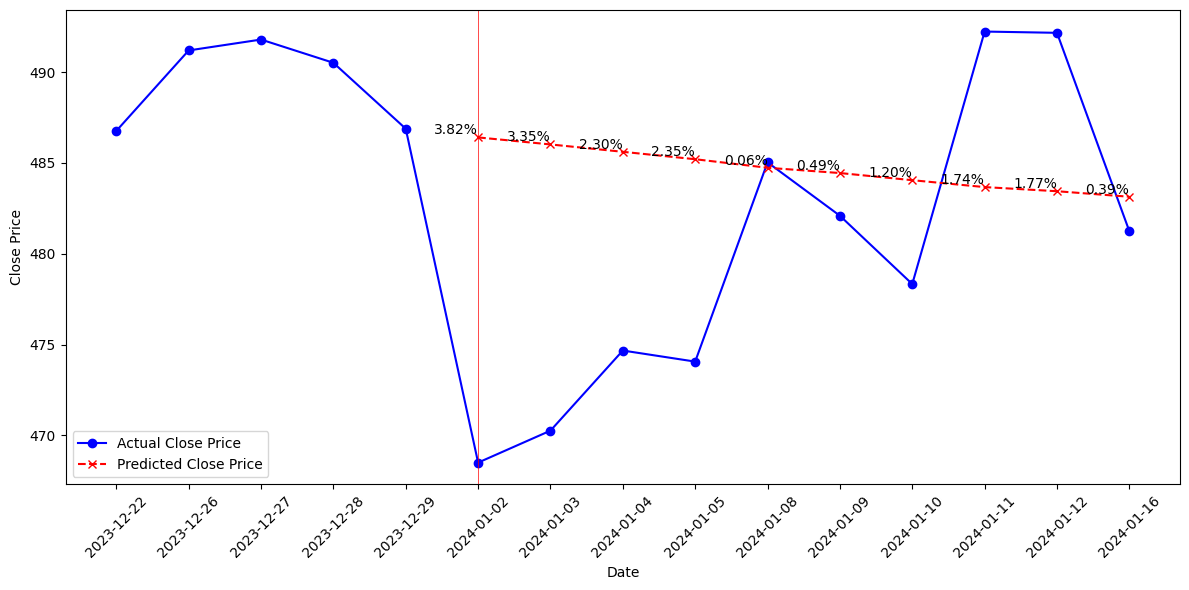

Average Error Rate: 1.75%


In [38]:
# 시각화
MODEL = 'transformer'
PRED_SIZE = 10
test_df = pd.read_csv('../../data/test.csv')
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = data_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d10_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d10_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
# plt.savefig(f'../../plots/best_plots/50trials_{filename}.png') #### 본인 파일 경로
plt.show()
# plt.clf()

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")

In [3]:
# r = pd.read_xml('../../data/final_results_50trials.xlsx')
r = pd.read_csv('../../data/final_results_50trials.csv',index_col=0)
# r = pd.read_csv('../../data/result_한진솔.csv')

test_df = pd.read_csv('../../data/test.csv')
lstm_r = r[r['model']=='lstm']
gru_r = r[r['model']=='gru']
transformer_r = r[r['model']=='transformer']

lstm_r = lstm_r.drop(columns='model').set_index('date')
gru_r = gru_r.drop(columns='model').set_index('date')
transformer_r = transformer_r.drop(columns='model').set_index('date')

lstm_r['Mean'] = lstm_r.mean(axis=1)
gru_r['Mean'] = gru_r.mean(axis=1)
transformer_r['Mean'] = transformer_r.mean(axis=1)
PRED_SIZE = 10
r.shape

(30, 52)

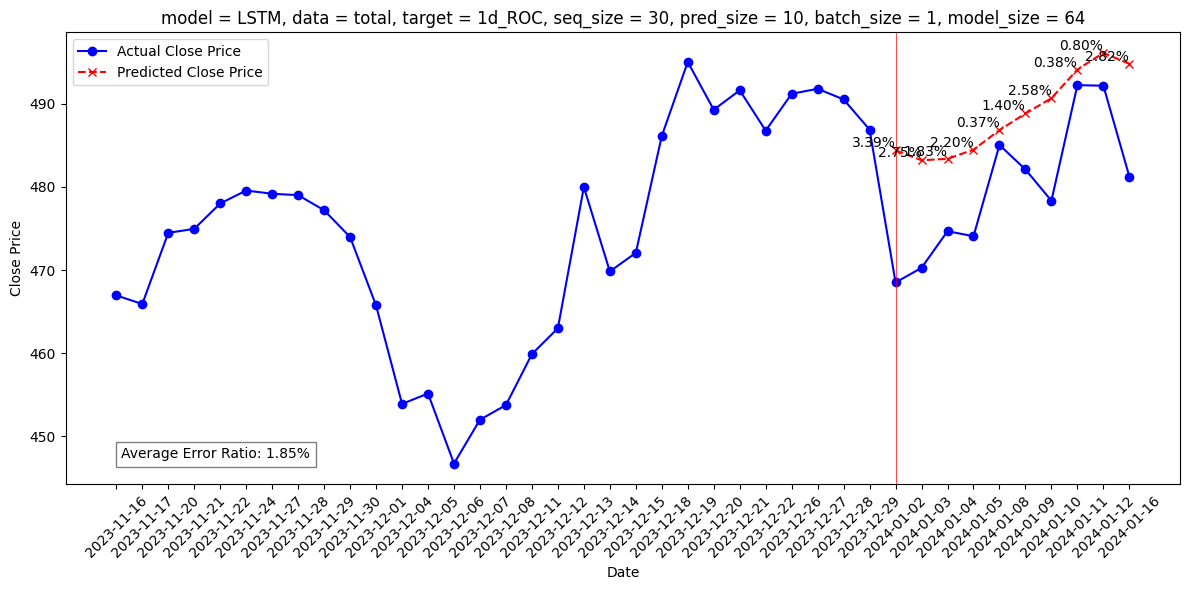

<Figure size 640x480 with 0 Axes>

In [31]:
### LSTM
MODEL = 'LSTM'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 64
preds_df = lstm_r
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d10_period = ['2023-12-15','2023-12-18','2023-12-19','2023-12-20','2023-12-21','2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d30_period = ['2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29']
d10_stock = stock_df.loc[d10_period,'Close'].to_list()
d30_stock = stock_df.loc[d30_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d30_period+period, d30_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)

# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.05, 0.05, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/d30_final_50_trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

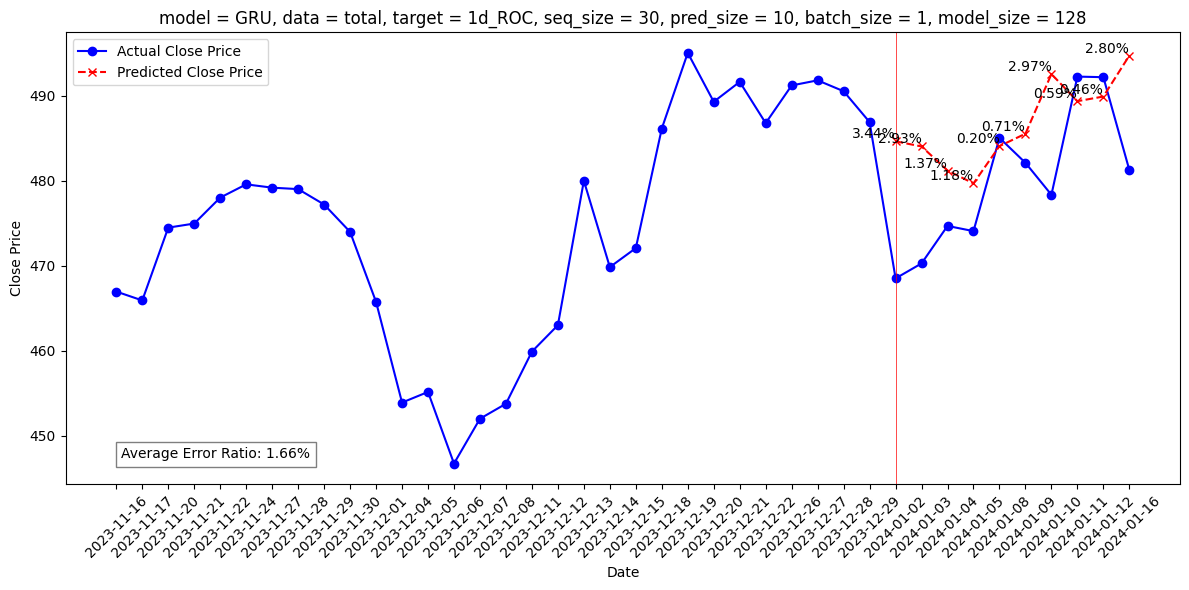

<Figure size 640x480 with 0 Axes>

In [32]:
### GRU
MODEL = 'GRU'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 128
preds_df = gru_r
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d10_period = ['2023-12-15','2023-12-18','2023-12-19','2023-12-20','2023-12-21','2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d30_period = ['2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29']
d10_stock = stock_df.loc[d10_period,'Close'].to_list()
d30_stock = stock_df.loc[d30_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d30_period+period, d30_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.05, 0.05, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/d30_final_50_trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

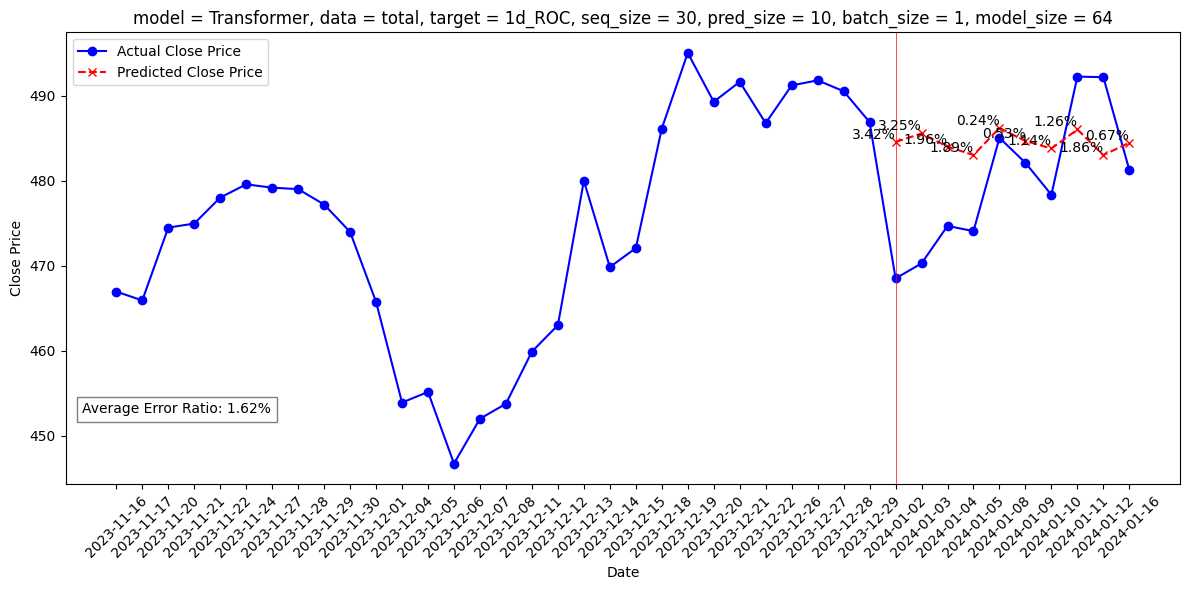

<Figure size 640x480 with 0 Axes>

In [30]:
### Transformer
MODEL = 'Transformer'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 64
preds_df = transformer_r
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()
d10_period = ['2023-12-15','2023-12-18','2023-12-19','2023-12-20','2023-12-21','2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d30_period = ['2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29']
d10_stock = stock_df.loc[d10_period,'Close'].to_list()
d30_stock = stock_df.loc[d30_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100


plt.figure(figsize=(12, 6))
plt.plot(d30_period+period, d30_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.015, 0.15, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/d30_final_50_trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

In [8]:
lstm_r.columns

Index(['test1', 'test2', 'test3', 'test4', 'test5', 'test6', 'test7', 'test8',
       'test9', 'test10', 'test11', 'test12', 'test13', 'test14', 'test15',
       'test16', 'test17', 'test18', 'test19', 'test20', 'test21', 'test22',
       'test23', 'test24', 'test25', 'test26', 'test27', 'test28', 'test29',
       'test30', 'test31', 'test32', 'test33', 'test34', 'test35', 'test36',
       'test37', 'test38', 'test39', 'test40', 'Mean'],
      dtype='object')

In [16]:
# 실제 1월 2일 가격
print('실제 1월 2일 가격:',test_df.iloc[0,1])
actual_0102 = test_df.iloc[0,1]
# 1월 2일 예측값
print('LSTM 24.1.2 : ',lstm_r['Mean'][0])
lstm_0102 = lstm_r['Mean'][0]
print('GRU 24.1.2 : ',gru_r['Mean'][0])
gru_0102 = gru_r['Mean'][0]
print('Transformer 24.1.2 : ',transformer_r['Mean'][0])
transformer_0102= transformer_r['Mean'][0]

실제 1월 2일 가격: 468.5
LSTM 24.1.2 :  484.387169978
GRU 24.1.2 :  484.61819225999983
Transformer 24.1.2 :  484.53942212399977


In [17]:
### 예측값들을 pred_0102 - (pred_0102-actual_0102) 만큼 조정해줌
lstm_adjusted = pd.DataFrame(lstm_r['Mean'] - (lstm_0102-actual_0102))
gru_adjusted = pd.DataFrame(gru_r['Mean'] - (gru_0102-actual_0102))
transformer_adjusted = pd.DataFrame(transformer_r['Mean'] - (transformer_0102-actual_0102))

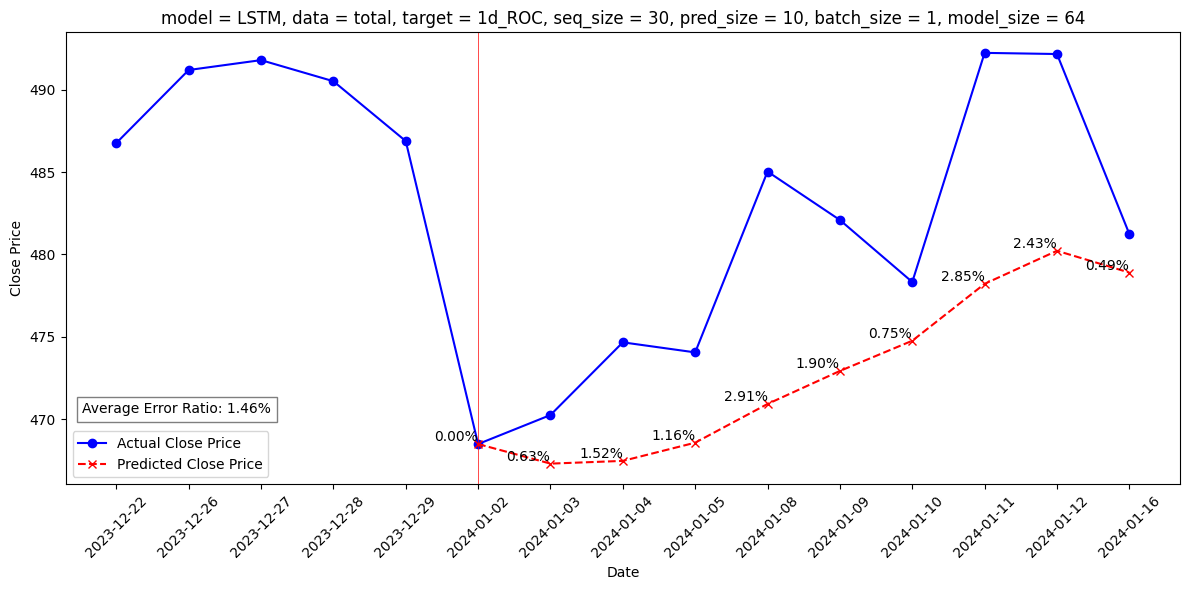

<Figure size 640x480 with 0 Axes>

In [21]:
### LSTM
MODEL = 'LSTM'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 64
preds_df = lstm_adjusted
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.015, 0.15, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/adjusted_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

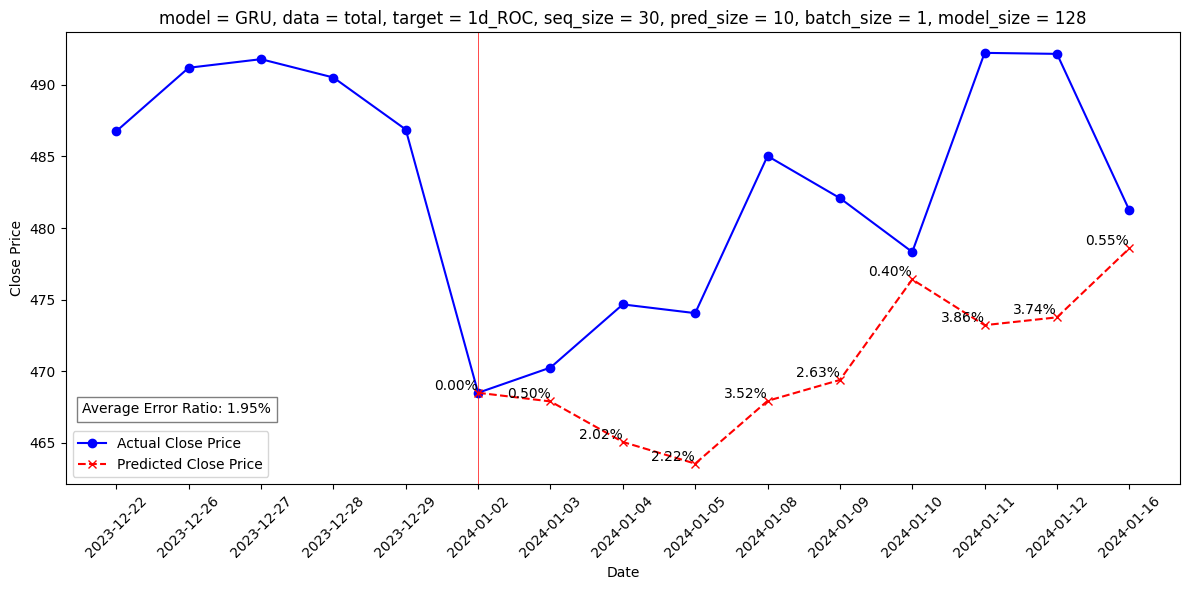

<Figure size 640x480 with 0 Axes>

In [19]:
### GRU
MODEL = 'GRU'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 128
preds_df = gru_adjusted
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.015, 0.15, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/adjusted_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

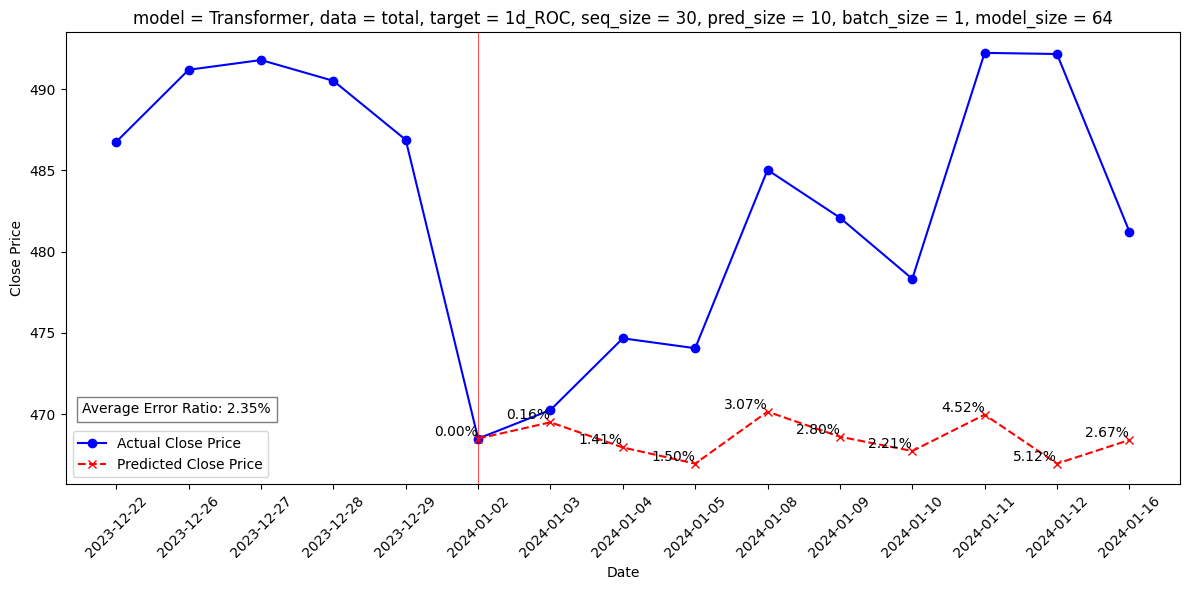

<Figure size 640x480 with 0 Axes>

In [20]:
### Transformer
MODEL = 'Transformer'
DATA = 'total'
SEQ_SIZE = 30
BATCH_SIZE = 1
MODEL_SIZE = 64
preds_df = transformer_adjusted
filename = f'{MODEL}_{DATA}_SEQ{SEQ_SIZE}_BATCH{BATCH_SIZE}_MODEL{MODEL_SIZE}'

# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.015, 0.15, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {DATA}, target = 1d_ROC, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {MODEL_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/찐막_결과/adjusted_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()